In [1]:
from models.simple_cnn import CNNModel
from models.residual import ResModel
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import callbacks
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 500
EPOCHS = 50

In [3]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

chunk_size = 10000
train_data_iter = pd.read_csv(train_file_path, chunksize=chunk_size)
train_data = pd.concat([chunk for chunk in tqdm(train_data_iter, desc='Loading training data')])
test_data_iter = pd.read_csv(test_file_path, chunksize=chunk_size)
test_data = pd.concat([chunk for chunk in tqdm(test_data_iter, desc='Loading test data')])

# Data dimensions and sizes
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

# Prepare data
x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)  # 62 classes for EMNIST ByClass
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

# Integer labels for sparse categorical crossentropy
y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

# Split the training data into training and validation sets
_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

# Prepare data for ResNet
x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

Loading training data: 70it [00:14,  4.78it/s]
Loading test data: 12it [00:02,  4.88it/s]


In [4]:
checkpoint_path_lenet = f"./checkpoints/checkpoints_lenet/weights.{int(time.time())}.hdf5"
checkpoint_path_resnet = f"./checkpoints/checkpoints_resnet/weights.{int(time.time())}.hdf5"
checkpoint_path_ours = f"./checkpoints/checkpoints_ours/weights.{int(time.time())}.hdf5"

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
checkpoint_lenet = callbacks.ModelCheckpoint(
    filepath=checkpoint_path_lenet, monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_resnet = callbacks.ModelCheckpoint(
    filepath=checkpoint_path_resnet, monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_ours = callbacks.ModelCheckpoint(filepath=checkpoint_path_ours,
                                            monitor='val_loss', save_best_only=True, verbose=1)

In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights inversely proportional to class frequencies
class_labels = np.unique(y_train_int)  # Ensure you have all unique class labels
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train_int)
class_weight_dict = dict(zip(class_labels, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 0.32514656874366543, 1: 0.2934805462032928, 2: 0.3289150683554273, 3: 0.3194967497787408, 4: 0.335238474421226, 5: 0.35813361856141507, 6: 0.32894710657761195, 7: 0.3160580856491615, 8: 0.3325971549024612, 9: 0.3322481204041541, 10: 1.7634885875515875, 11: 2.890511251207952, 12: 1.1144254686485393, 13: 2.48558438063883, 14: 2.287478423003809, 15: 1.2266911170219, 16: 4.4493816141782485, 17: 3.593913421597684, 18: 0.9390343808957151, 19: 2.978900892526866, 20: 4.62825122680853, 21: 2.227625755383437, 22: 1.2524714965365151, 23: 1.3674236652023042, 24: 0.45073817393263654, 25: 1.34921320222185, 26: 4.307500822909809, 27: 2.223714208841938, 28: 0.5425319661285141, 29: 1.1434810310929877, 30: 0.8938016705323221, 31: 2.4116262640999455, 32: 2.4036161175525197, 33: 4.031532803614752, 34: 2.3776676685012603, 35: 4.169235364396655, 36: 1.1230730446163253, 37: 2.1905387968613774, 38: 3.9714786105385618, 39: 1.1054273797581966, 40: 0.4568561478843737, 41: 4.374456794250376, 42

In [7]:
# Initialize models
lenet_model = LeNetModel()
lenet_model2 = LeNetModel()


# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lenet_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = []
training_time = []

In [11]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[reduce_lr, checkpoint_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7957
Epoch 1: val_loss improved from inf to 0.45883, saving model to ./checkpoints/checkpoints_lenet/weights.1716376594.hdf5
1257/1257 [==============================] - 10s 5ms/step - loss: 0.6526 - accuracy: 0.7957 - val_loss: 0.4588 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 2/50
  26/1257 [..............................] - ETA: 5s - loss: 0.4413 - accuracy: 0.8468

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1241/1257 [============================>.] - ETA: 0s - loss: 0.4357 - accuracy: 0.8459
Epoch 2: val_loss improved from 0.45883 to 0.42968, saving model to ./checkpoints/checkpoints_lenet/weights.1716376594.hdf5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.4355 - accuracy: 0.8460 - val_loss: 0.4297 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 3/50
1239/1257 [============================>.] - ETA: 0s - loss: 0.4077 - accuracy: 0.8532
Epoch 3: val_loss improved from 0.42968 to 0.40826, saving model to ./checkpoints/checkpoints_lenet/weights.1716376594.hdf5
1257/1257 [==============================] - 4s 4ms/step - loss: 0.4077 - accuracy: 0.8532 - val_loss: 0.4083 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 4/50
1249/1257 [============================>.] - ETA: 0s - loss: 0.3929 - accuracy: 0.8571
Epoch 4: val_loss improved from 0.40826 to 0.40422, saving model to ./checkpoints/checkpoints_lenet/weights.1716376594.hdf5
1257/1257 [==============================] - 5s 4ms/s

In [16]:
start_time = time.time()
history.append(lenet_model2.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int), epochs=EPOCHS,
               batch_size=BATCH_SIZE, callbacks=[reduce_lr, checkpoint_lenet], class_weight=class_weight_dict))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1252/1257 [============================>.] - ETA: 0s - loss: 0.9436 - accuracy: 0.7004
Epoch 1: val_loss did not improve from 0.37443
1257/1257 [==============================] - 7s 5ms/step - loss: 0.9426 - accuracy: 0.7006 - val_loss: 0.6309 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 2/50
1253/1257 [============================>.] - ETA: 0s - loss: 0.6502 - accuracy: 0.7655
Epoch 2: val_loss did not improve from 0.37443
1257/1257 [==============================] - 6s 5ms/step - loss: 0.6501 - accuracy: 0.7655 - val_loss: 0.5715 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.7779
Epoch 3: val_loss did not improve from 0.37443
1257/1257 [==============================] - 5s 4ms/step - loss: 0.6056 - accuracy: 0.7779 - val_loss: 0.5657 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 4/50
1247/1257 [============================>.] - ETA: 0s - loss: 0.5803 - accuracy: 0.7841
Epoch 4: val_loss did not imp

In [23]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_lenet_withWeight, acc_lenet_withWeight = lenet_model2.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 4s 1ms/step - loss: 0.4787 - accuracy: 0.8104


In [24]:
from datetime import datetime
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

In [25]:
results = {
    "Model": ["LeNet-5", "LeNet-5 with sample_weight"],
    "Loss": [loss_lenet, loss_lenet_withWeight],
    "Accuracy": [acc_lenet, acc_lenet_withWeight],
    "Training Time": training_time
}
result_path = './results'
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_weight_{_time}.csv', index=False)

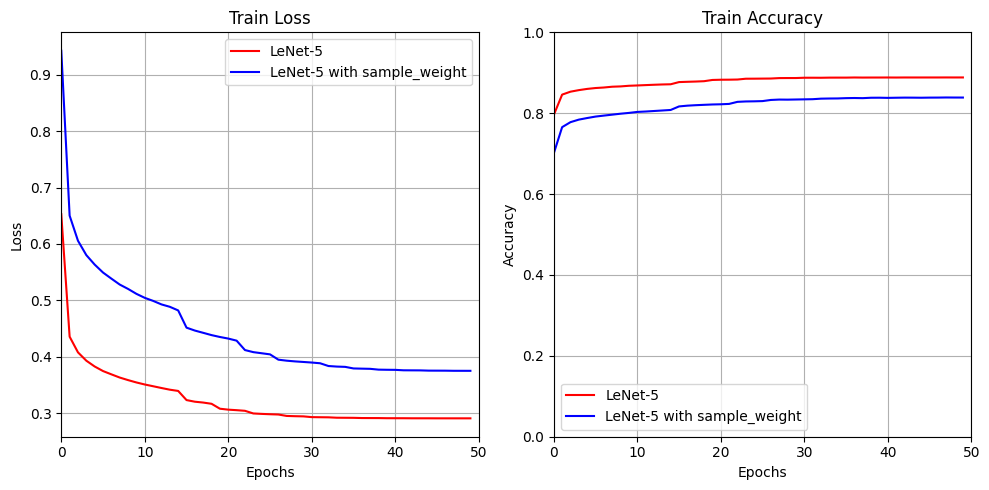

In [26]:
colors = ["red", "blue", "green"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()

In [27]:
# training_time.append("")
results = {
    "Model": ["LeNet-5", "LeNet-5 with sample_weight"],
    "Loss": [loss_lenet, loss_lenet_withWeight],
    "Accuracy": [acc_lenet, acc_lenet_withWeight],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

/tmp/ipykernel_1893026/891141831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


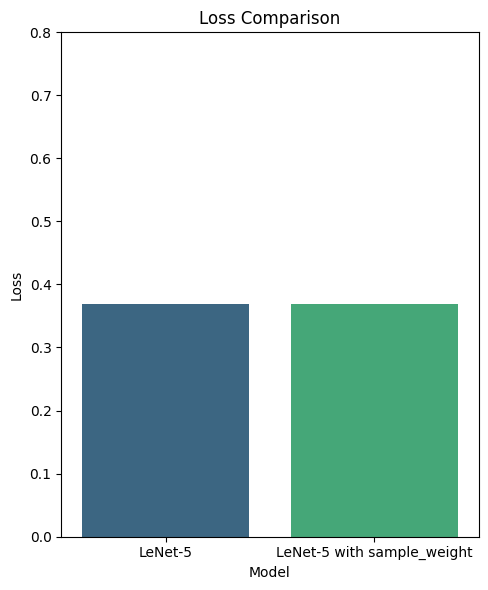

/tmp/ipykernel_1893026/891141831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


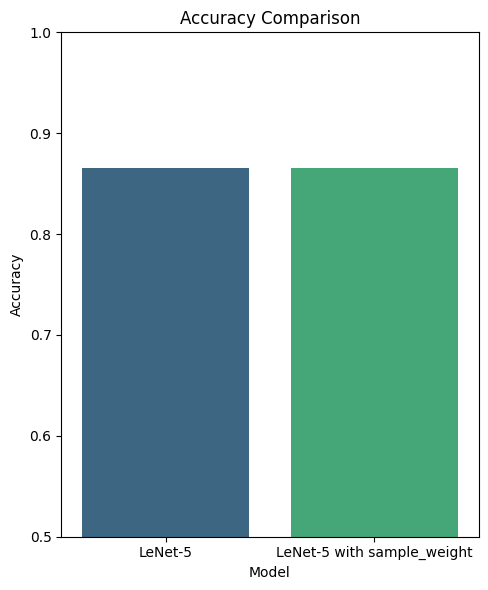

/tmp/ipykernel_1893026/891141831.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


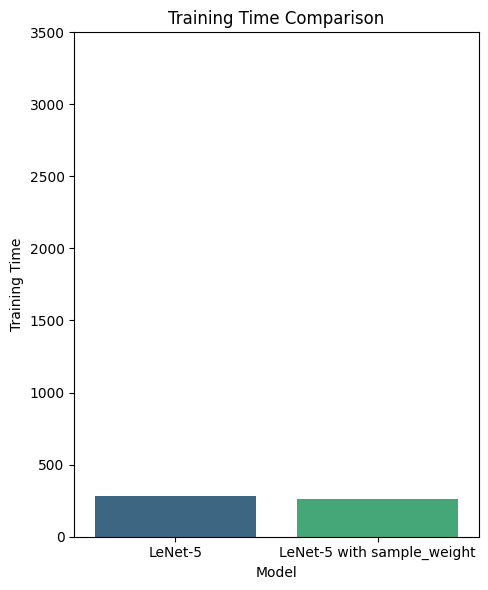

In [22]:
import seaborn as sns


result_path = './results'
metrics = ["Loss", "Accuracy", "Training Time"]
limits = [[0, 0.8], [0.5, 1.0], [0, 3500]]
for metric, y_limit in zip(metrics, limits):
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.ylim(y_limit)
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()